# Deep dive into vector data cubes

Data cubes, as structures for representing multi-dimensional data, are typically used for raster data. When we deal with vector data, thinking of points, polygons and the like, we tend to represent it as tabular data. However, when the nature of the vector dataset is multi-dimensional, this is not sufficient. This tutorial will provide a deep dive into the concept of vector data cubes, an extension of the generic data cube model to support vector geometries either as coordinates along one or more dimensions or as variables within the cube itself. You will learn how to create such objects in Python using `Xarray` and `Xvec`. The tutorial is organised along a series of applied use cases that show different applications of vector data cubes. Starting with the one resulting from zonal statistics applied to a multidimensional raster cube, we will cover spatial subsetting, plotting, CRS transformations, constructive operations and I/O. Using the cube that captures origin-destination data, we will explore the application of multiple dimensions supported by vector geometry. Finally, the use case of time-evolving geometry will demonstrate the vector data cube composed of geometries both as coordinates along the dimensions and as variables in the cube. This includes an introduction to the concept of summary geometry supported by spatial masking and the more complex case of zonal statistics based on time-evolving geometry. 

**Outline**

- [ ] introduction of the concept of VDC, both types
- [ ] implementations in Python (xvec) and R (stars, post)
- [ ] use cases
    - [ ] *include examples of various features in the use cases - plotting, subsetting, zonal stats etc.*
    - [ ] coordinate geometry
        - [x] administrative boundaries
        - [ ] zonal stats
        - [x] plotting on coordinate geometry
        - [x] spatial subsetting
        - [ ] IO (CF conventions netCDF)
        - [ ] CRS transformation
        - [ ] constructive ops on elements (buffer etc)
        - [ ] conversions to wide and long tables (sf, geopandas)
    - [ ] multiple coordinate geometries
        - [ ] origin-destination cube (NY taxi data)
        - [ ] subsetting along multiple dimensions
        - [ ] *IO (xvec can do CF conventions but I don't think stars can read it?)*
    - [ ] variable geometry + summary coordinate geometry
        - [ ] cities in time, glaciers ...
        - [ ] summary geometry
        - [ ] zonal stats from aligned raster possibly with CRS transformations to get the same CRS
        - [ ] constructive ops on elements (buffer etc)
        - [ ] masking based on spatial query
        - [ ] *IO* 

In [24]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import contextily
import shapely

import rioxarray  # noqa: F401

import xvec  # noqa: F401

xvec.__version__

'0.4.1.dev5+ga84b3e0'

## Coordinate geometry

- Use FUA as geometry
- Use population grid as raster input - ideally some mdim population

In [2]:
era = xr.open_dataset("./data/era5.grib", engine="cfgrib")
era

/Users/martin/dev/lps25/.pixi/envs/default/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 44MB
Dimensions:     (time: 60, latitude: 169, longitude: 365)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 480B 2020-01-01 2020-02-01 ... 2024-12-01
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 1kB 72.0 71.75 71.5 71.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 3kB -31.0 -30.75 -30.5 ... 59.5 59.75 60.0
    valid_time  (time) datetime64[ns] 480B ...
Data variables:
    d2m         (time, latitude, longitude) float32 15MB ...
    t2m         (time, latitude, longitude) float32 15MB ...
    sp          (time, latitude, longitude) float32 15MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-18T11:53 GRIB to CDM+CF via cfgrib-0.9.1...

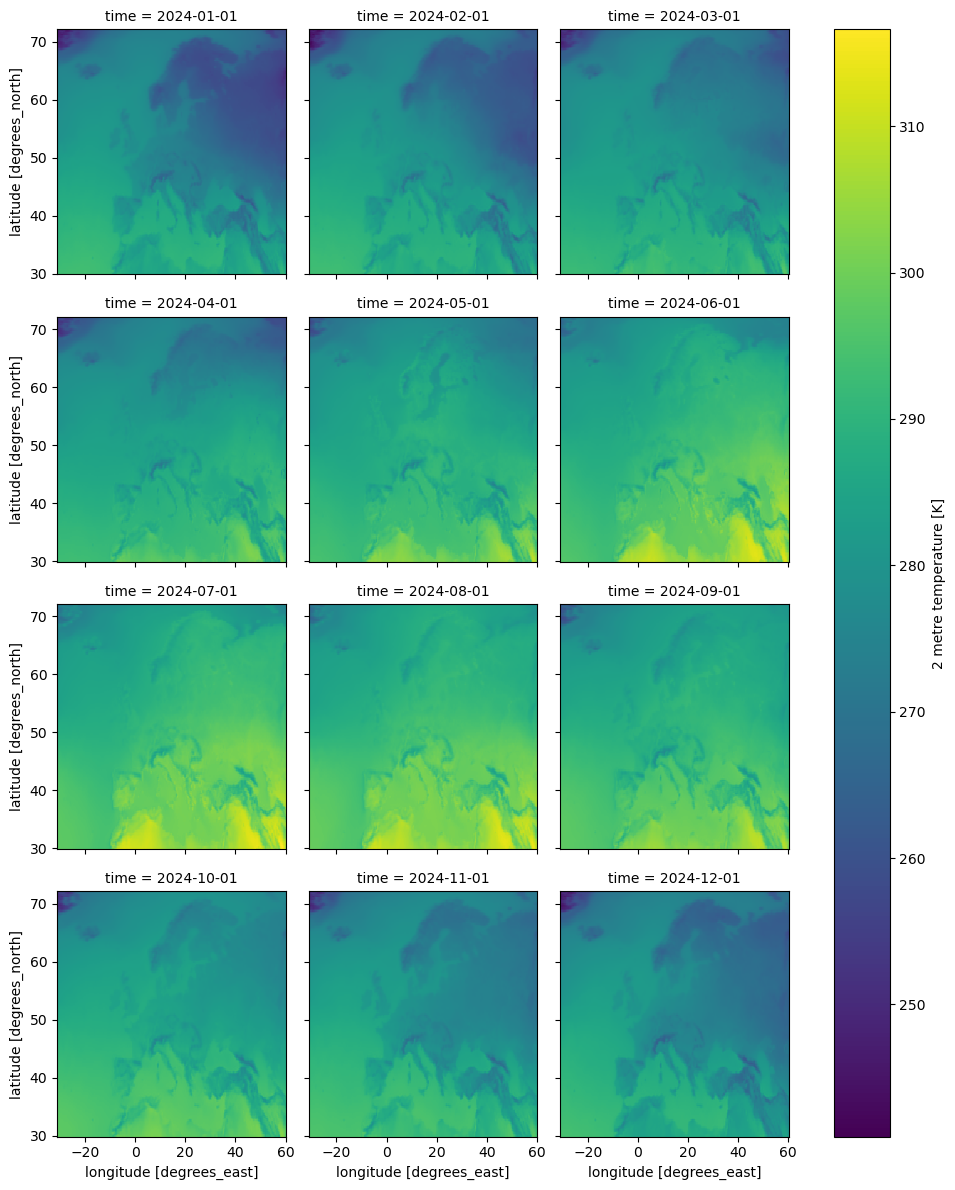

In [3]:
era.sel(time=slice("2024-01-01", "2024-12-31")).t2m.plot(col="time", col_wrap=3)

In [4]:
fua = gpd.read_file("./data/ghs_fua.gpkg").set_index("eFUA_name")
fua.head()

,eFUA_ID,UC_num,UC_IDs,Commuting,Cntry_ISO,Cntry_name,FUA_area,UC_area,FUA_p_2015,UC_p_2015,Com_p_2015,geometry
eFUA_name,,,,,,,,,,,,
Herat,1.0,1.0,5959,1.0,AFG,Afghanistan,139.0,60.0,888811.175807,844574.564331,44236.611476,"MULTIPOLYGON (((5529000 4155000, 5531000 41550..."
Guzarah,192.0,1.0,5964,1.0,AFG,Afghanistan,32.0,16.0,169489.573231,160204.260864,9285.312366,"MULTIPOLYGON (((5541000 4139000, 5542000 41390..."
Shindand,354.0,1.0,5968,0.0,AFG,Afghanistan,12.0,12.0,147553.403870,147553.403870,0.000000,"MULTIPOLYGON (((5573000 4030000, 5574000 40300..."
Qala i Naw,505.0,1.0,5970,0.0,AFG,Afghanistan,3.0,3.0,79809.722656,79809.722656,0.000000,"MULTIPOLYGON (((5592000 4221000, 5590000 42210..."
Farah,648.0,1.0,5973,1.0,AFG,Afghanistan,32.0,16.0,131508.797060,122843.460327,8665.336733,"MULTIPOLYGON (((5607000 3923000, 5608000 39230..."


In [5]:
fua = fua.to_crs(4326)

In [6]:
bds = era.rio.bounds()
fua_eu = fua.cx[bds[0] : bds[2], bds[1] : bds[3]]

In [7]:
zonal = era.xvec.zonal_stats(
    fua_eu.geometry,
    x_coords="longitude",
    y_coords="latitude",
    stats=["mean", "min", "max"],
    all_touched=True,
)
zonal

<xarray.Dataset> Size: 3MB
Dimensions:           (time: 60, zonal_statistics: 3, geometry: 1492)
Coordinates:
  * time              (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * zonal_statistics  (zonal_statistics) <U4 48B 'mean' 'min' 'max'
    number            int64 8B 0
    step              timedelta64[ns] 8B 00:00:00
    surface           float64 8B 0.0
    valid_time        (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * geometry          (geometry) geometry 12kB MULTIPOLYGON (((19.53621592009...
    eFUA_name         (geometry) object 12kB 'Shkoder' 'Durrës' ... 'Nukus'
Data variables:
    d2m               (geometry, zonal_statistics, time) float32 1MB 272.5 .....
    t2m               (geometry, zonal_statistics, time) float32 1MB 278.0 .....
    sp                (geometry, zonal_statistics, time) float32 1MB 9.821e+0...
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-18T11:53 GRIB to CDM+CF via cfgrib-0.9.1...

## Selection by geometry

### Geometry as a label

You can select data based on geometry as with any other index, treating it as a label.

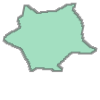

In [8]:
vienna = fua_eu.geometry.loc["Vienna"]
vienna

In [9]:
zonal.sel(geometry=vienna)

<xarray.Dataset> Size: 3kB
Dimensions:           (time: 60, zonal_statistics: 3)
Coordinates:
  * time              (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * zonal_statistics  (zonal_statistics) <U4 48B 'mean' 'min' 'max'
    number            int64 8B 0
    step              timedelta64[ns] 8B 00:00:00
    surface           float64 8B 0.0
    valid_time        (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
    geometry          object 8B MULTIPOLYGON (((16.619918426745453 48.4764179...
    eFUA_name         <U6 24B 'Vienna'
Data variables:
    d2m               (zonal_statistics, time) float32 720B 271.7 ... 273.0
    t2m               (zonal_statistics, time) float32 720B 274.1 ... 276.2
    sp                (zonal_statistics, time) float32 720B 9.929e+04 ... 1.0...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-18T11:53 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
fua_austria = fua_eu[fua_eu["Cntry_name"] == "Austria"].geometry
fua_austria

eFUA_name
Innsbruck     MULTIPOLYGON (((11.62018 47.32001, 11.64561 47...
Salzburg      MULTIPOLYGON (((13.19978 47.90172, 13.21258 47...
Linz          MULTIPOLYGON (((14.38089 48.42922, 14.49687 48...
Klagenfurt    MULTIPOLYGON (((14.38685 46.76864, 14.39948 46...
Graz          MULTIPOLYGON (((15.31888 47.24512, 15.33158 47...
Vienna        MULTIPOLYGON (((16.61992 48.47642, 16.60702 48...
Name: geometry, dtype: geometry

In [11]:
zonal.sel(geometry=fua_austria.values)

<xarray.Dataset> Size: 14kB
Dimensions:           (time: 60, zonal_statistics: 3, geometry: 6)
Coordinates:
  * time              (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * zonal_statistics  (zonal_statistics) <U4 48B 'mean' 'min' 'max'
    number            int64 8B 0
    step              timedelta64[ns] 8B 00:00:00
    surface           float64 8B 0.0
    valid_time        (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * geometry          (geometry) geometry 48B MULTIPOLYGON (((11.620178432404...
    eFUA_name         (geometry) object 48B 'Innsbruck' 'Salzburg' ... 'Vienna'
Data variables:
    d2m               (geometry, zonal_statistics, time) float32 4kB 263.7 .....
    t2m               (geometry, zonal_statistics, time) float32 4kB 267.8 .....
    sp                (geometry, zonal_statistics, time) float32 4kB 8.314e+0...
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-18T11:53 GRIB to CDM+CF via cfgrib-0.9.1...

### Nearest

Alternatively, you can select based on the nearest neighbor.

In [12]:
zonal.sel(geometry=shapely.Point(15.56, 48.06), method="nearest")

<xarray.Dataset> Size: 3kB
Dimensions:           (time: 60, zonal_statistics: 3, geometry: 1)
Coordinates:
  * time              (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * zonal_statistics  (zonal_statistics) <U4 48B 'mean' 'min' 'max'
    number            int64 8B 0
    step              timedelta64[ns] 8B 00:00:00
    surface           float64 8B 0.0
    valid_time        (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * geometry          (geometry) geometry 8B MULTIPOLYGON (((16.6199184267454...
    eFUA_name         (geometry) object 8B 'Vienna'
Data variables:
    d2m               (geometry, zonal_statistics, time) float32 720B 271.7 ....
    t2m               (geometry, zonal_statistics, time) float32 720B 274.1 ....
    sp                (geometry, zonal_statistics, time) float32 720B 9.929e+...
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-18T11:53 GRIB to CDM+CF via cfgrib-0.9.1...

### Spatial query

Spatial-aware data selection using the “query” mode with a single geometry and a given predicate:

In [13]:
zonal.sel(geometry=shapely.box(9.4, 46, 17.2, 49.5), method="intersects")

<xarray.Dataset> Size: 71kB
Dimensions:           (time: 60, zonal_statistics: 3, geometry: 32)
Coordinates:
  * time              (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * zonal_statistics  (zonal_statistics) <U4 48B 'mean' 'min' 'max'
    number            int64 8B 0
    step              timedelta64[ns] 8B 00:00:00
    surface           float64 8B 0.0
    valid_time        (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * geometry          (geometry) geometry 256B MULTIPOLYGON (((15.94954636457...
    eFUA_name         (geometry) object 256B 'Zagreb' 'Udine' ... 'Olomouc'
Data variables:
    d2m               (geometry, zonal_statistics, time) float32 23kB 271.7 ....
    t2m               (geometry, zonal_statistics, time) float32 23kB 274.0 ....
    sp                (geometry, zonal_statistics, time) float32 23kB 1.003e+...
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-18T11:53 GRIB to CDM+CF via cfgrib-0.9.1...

In [14]:
zonal_subset = zonal.xvec.query(
    "geometry",
    [
        shapely.Point(15.56, 48.06),
        shapely.Point(13.2, 46.0),
    ],
    predicate="dwithin",
    distance=3,
    unique=True,
)
zonal_subset

<xarray.Dataset> Size: 129kB
Dimensions:           (time: 60, zonal_statistics: 3, geometry: 59)
Coordinates:
  * time              (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * zonal_statistics  (zonal_statistics) <U4 48B 'mean' 'min' 'max'
    number            int64 8B 0
    step              timedelta64[ns] 8B 00:00:00
    surface           float64 8B 0.0
    valid_time        (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * geometry          (geometry) geometry 472B MULTIPOLYGON (((11.62017843240...
    eFUA_name         (geometry) object 472B 'Innsbruck' ... 'Maribor'
Data variables:
    d2m               (geometry, zonal_statistics, time) float32 42kB 263.7 ....
    t2m               (geometry, zonal_statistics, time) float32 42kB 267.8 ....
    sp                (geometry, zonal_statistics, time) float32 42kB 8.314e+...
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-18T11:53 GRIB to CDM+CF via cfgrib-0.9.1...

## Plotting using coordinate geometries

When you have coordinate geometry, you can use it to visualise the data from the DataArrray.

The resulting Dataset is 3-dimensional but each suplot can only contain a single array of values. Subset the data to get a 2-dimesional cube, allowing you to use one dimension (geometry) as a container to show the other data along the other dimension.

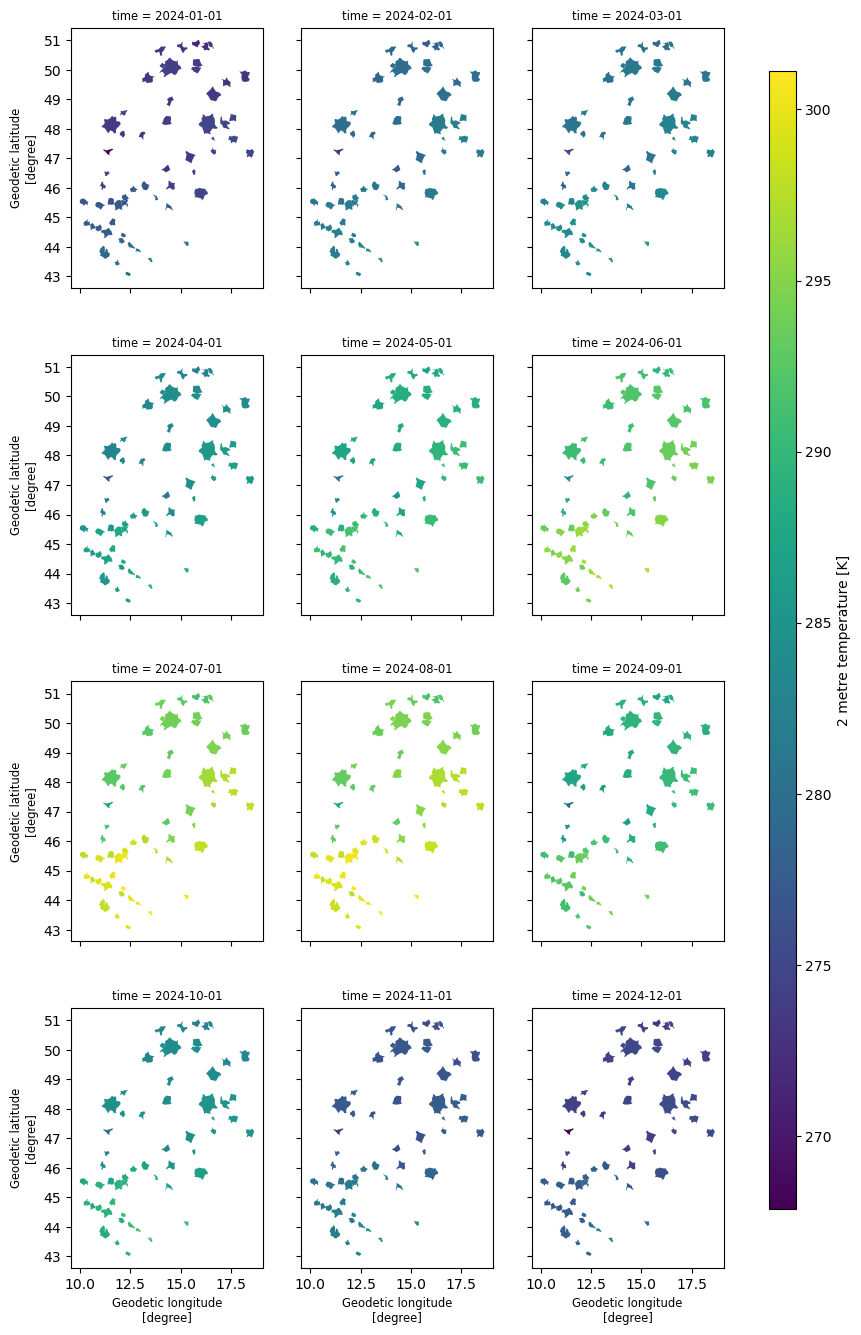

In [15]:
fig, ax = zonal_subset.sel(
    time=slice("2024-01-01", "2024-12-31"), zonal_statistics="mean"
).t2m.xvec.plot(col="time", col_wrap=3)

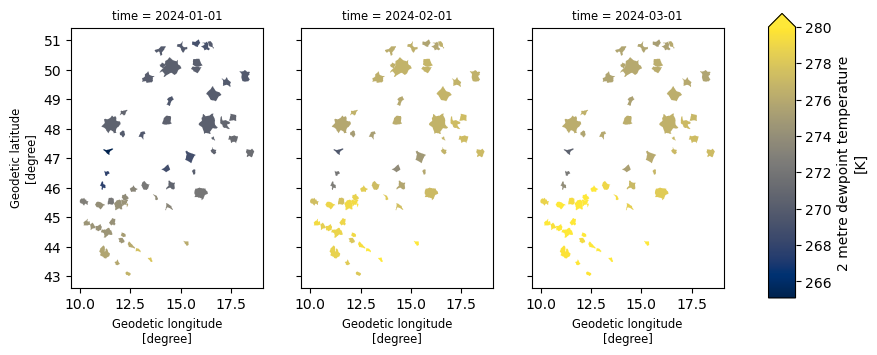

In [ ]:
fig, ax = zonal_subset.sel(
    time=slice("2024-01-01", "2024-03-31"), zonal_statistics="mean"
).d2m.xvec.plot(col="time", col_wrap=3, cmap="cividis", vmax=280)

The defualt colormap will automatically adapt depnding on the data, as usally in Xarray.

In [33]:
diff = zonal_subset.d2m - zonal_subset.d2m.median()
diff

<xarray.DataArray 'd2m' (geometry: 59, zonal_statistics: 3, time: 60)> Size: 42kB
array([[[-16.066162 , -13.5581665, -12.462952 , ...,  -2.5718994,
         -11.501892 , -15.426147 ],
        [-17.375732 , -14.641663 , -13.31012  , ...,  -3.630005 ,
         -12.717712 , -16.713257 ],
        [-15.330811 , -13.018616 , -12.044495 , ...,  -2.1026611,
         -10.848572 , -14.750366 ]],

       [[ -9.25708  ,  -7.66803  ,  -7.4277954, ...,   2.437378 ,
          -5.545349 ,  -8.315796 ],
        [-10.850342 ,  -8.840881 ,  -8.157776 , ...,   1.8739014,
          -6.3270874,  -9.557007 ],
        [ -7.651123 ,  -6.5010376,  -6.6831665, ...,   3.008667 ,
          -4.7684937,  -7.09021  ]],

       [[ -7.653076 ,  -6.370575 ,  -7.497223 , ...,   1.9313354,
          -5.3985596,  -7.5624695],
        [ -8.64917  ,  -7.135803 ,  -8.470276 , ...,   1.118042 ,
          -6.213806 ,  -8.515991 ],
        [ -6.9851074,  -5.9033813,  -6.8413696, ...,   2.4735107,
          -4.8974   ,  -7.0062256]],
...
       [[ -8.60376  ,  -6.4868774,  -7.4922485, ...,   1.3597412,
          -5.6068726,  -7.1605225],
        [ -8.748779 ,  -6.5615845,  -7.6030884, ...,   1.1395264,
          -5.807556 ,  -7.2698975],
        [ -8.449951 ,  -6.395569 ,  -7.349182 , ...,   1.602417 ,
          -5.383728 ,  -7.0511475]],

       [[ -8.443726 ,  -7.0502625,  -6.8999634, ...,   2.930542 ,
          -5.1348877,  -8.524567 ],
        [ -9.096436 ,  -7.836975 ,  -7.2573853, ...,   2.5184326,
          -5.881775 ,  -9.082397 ],
        [ -7.80542  ,  -6.5401   ,  -6.567932 , ...,   3.2489014,
          -4.5770874,  -8.033569 ]],

       [[ -9.467529 ,  -7.546936 ,  -6.9605103, ...,   2.7039795,
          -5.361267 ,  -8.482788 ],
        [ -9.809326 ,  -7.973694 ,  -7.2964478, ...,   2.4500732,
          -5.7626343,  -8.984741 ],
        [ -9.125732 ,  -7.120178 ,  -6.6245728, ...,   2.9578857,
          -4.9599   ,  -7.980835 ]]], shape=(59, 3, 60), dtype=float32)
Coordinates:
  * time              (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * zonal_statistics  (zonal_statistics) <U4 48B 'mean' 'min' 'max'
    number            int64 8B 0
    step              timedelta64[ns] 8B 00:00:00
    surface           float64 8B 0.0
    valid_time        (time) datetime64[ns] 480B 2020-01-01 ... 2024-12-01
  * geometry          (geometry) geometry 472B MULTIPOLYGON (((11.62017843240...
    eFUA_name         (geometry) object 472B 'Innsbruck' ... 'Maribor'
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)

(<Figure size 900x406.465 with 4 Axes>,
 array([[<Axes: title={'center': 'time = 2024-01-01'}, xlabel='Geodetic longitude\n[degree]', ylabel='Geodetic latitude\n[degree]'>,
         <Axes: title={'center': 'time = 2024-02-01'}, xlabel='Geodetic longitude\n[degree]'>,
         <Axes: title={'center': 'time = 2024-03-01'}, xlabel='Geodetic longitude\n[degree]'>]],
       dtype=object))

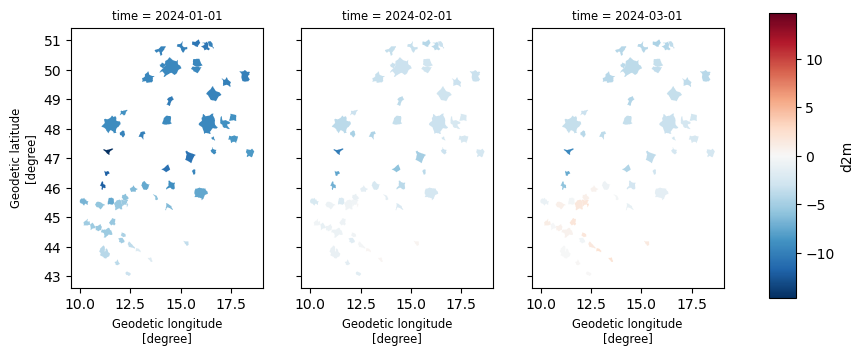

In [34]:
diff.sel(time=slice("2024-01-01", "2024-03-31"), zonal_statistics="mean").xvec.plot(col='time')

However, you can also use 3-dimensions and facet subplots along two of the dimensions.

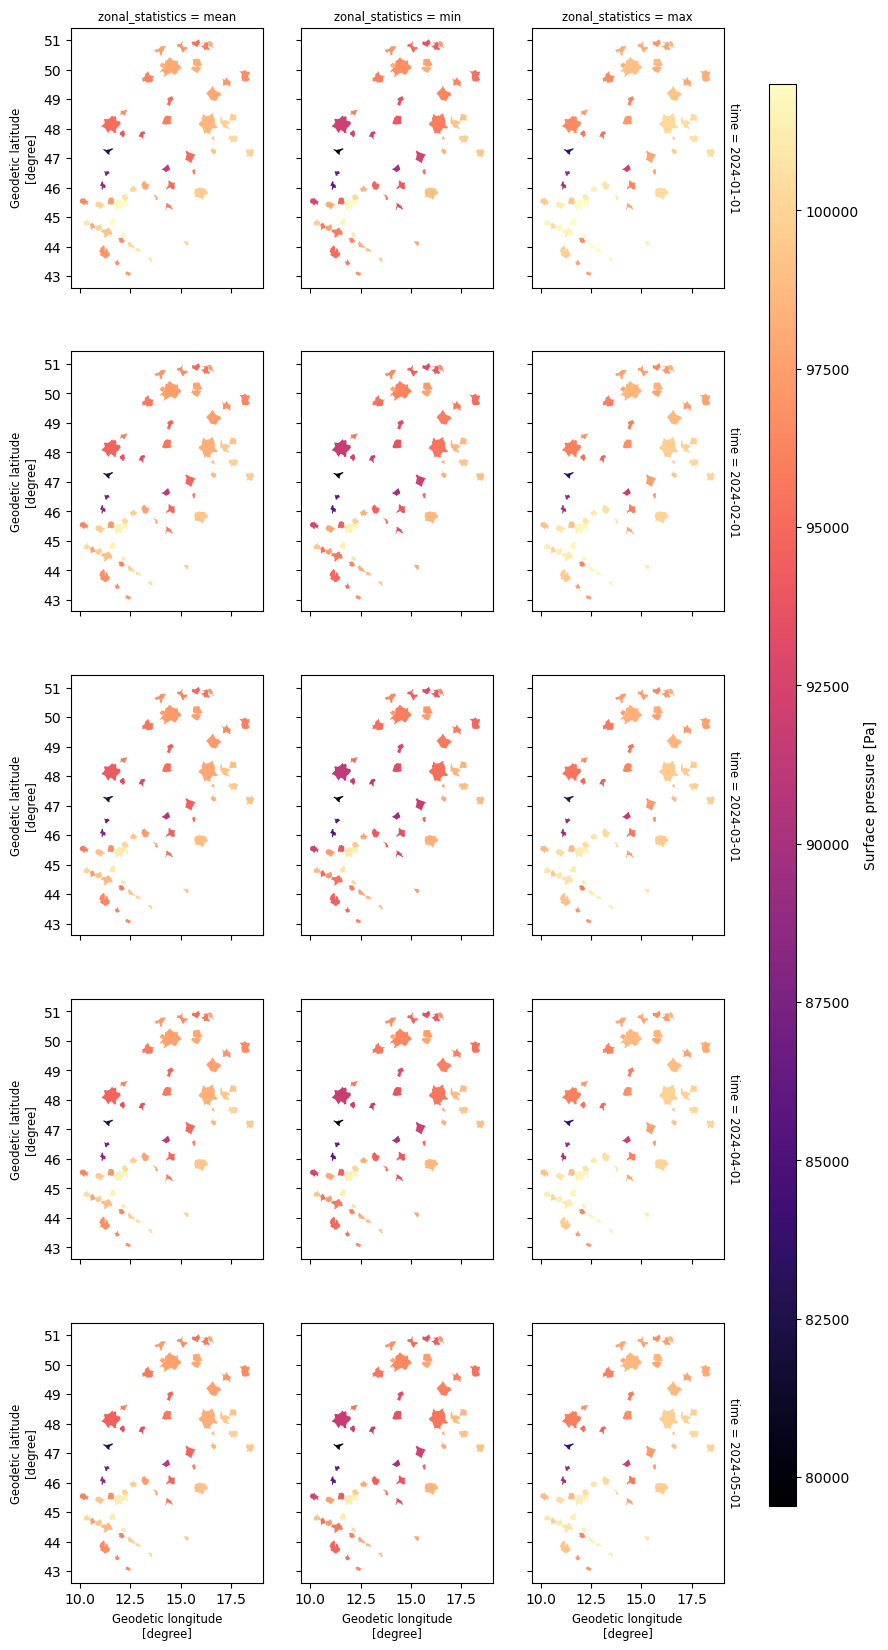

In [ ]:
fig, ax = zonal_subset.sel(time=slice("2024-01-01", "2024-05-31")).sp.xvec.plot(
    col="zonal_statistics", row="time", cmap="magma"
)

When slicing down to a 1-D array, no arguments are needed. Each Axes can be further adapted in a typical way, e.g. by inluding a contextual basemap.

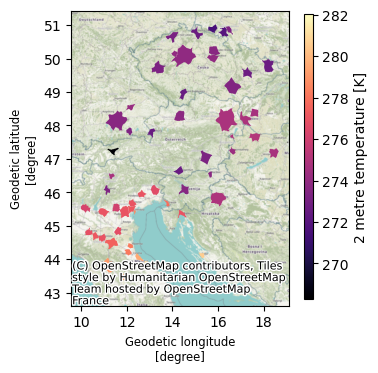

In [35]:
fig, ax = zonal_subset.sel(time="2024-01-01", zonal_statistics="mean").t2m.xvec.plot(cmap='magma')
contextily.add_basemap(ax=ax, crs=zonal_subset.proj.crs)

## Coordinate geometry across multiple dimensions

In [ ]:
# Load the data
trips = pd.read_parquet(
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet"
)  # 33MB
zones = gpd.read_file(
    "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"
)  # 1MB
lookup = pd.read_csv("https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv")

# create variables for day and hour
trips["date"] = trips.tpep_pickup_datetime.dt.date
trips["hour"] = trips.tpep_pickup_datetime.dt.hour

# use groupby over five columns to create a mutli-indexed DataFrame with aggregations
# and create a Dataset backed by sparse arrays
taxi_trips = xr.Dataset.from_dataframe(
    trips[  # filter only trips with known locations
        trips.PULocationID.isin(zones.LocationID)
        & trips.DOLocationID.isin(zones.LocationID)
    ]
    .groupby(["payment_type", "date", "hour", "PULocationID", "DOLocationID"])
    .agg(
        {
            "trip_distance": "mean",
            "VendorID": "count",
            "tip_amount": "mean",
            "fare_amount": "mean",
        }
    ),
)

# Replace int codes with labels
taxi_trips["payment_type"] = [
    "Credit card",
    "Cash",
    "No charge",
    "Dispute",
    "Unknown",
    "Voided trip",
]

# create linkable geometry variable
taxi_zones = (
    lookup.merge(
        zones.dissolve("LocationID")[["zone", "geometry"]],
        left_on="Zone",
        right_on="zone",
        how="left",
    )
    .set_index("LocationID")
    .geometry
)
# replace location IDs with actual geometries
taxi_trips["PULocationID"] = taxi_zones.loc[taxi_trips.PULocationID].values
taxi_trips["DOLocationID"] = taxi_zones.loc[taxi_trips.DOLocationID].values

# rename
taxi_trips = taxi_trips.rename(
    {"PULocationID": "origin", "DOLocationID": "destination", "VendorID": "trips_count"}
)

# assing GeometryIndex
taxi_trips = taxi_trips.xvec.set_geom_indexes(["origin", "destination"], crs=zones.crs)
taxi_trips